In [22]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt


In [23]:
train_path="data/uab_data/train"
# test_path="data/uab_data/Images"
val_path="data/uab_data/val"

In [24]:
x_train=[]

for folder in os.listdir(train_path):

    sub_path=train_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(224,224))

        x_train.append(img_arr)

# x_test=[]
#
# for folder in os.listdir(test_path):
#
#     sub_path=test_path+"/"+folder
#
#     for img in os.listdir(sub_path):
#
#         image_path=sub_path+"/"+img
#
#         img_arr=cv2.imread(image_path)
#
#         img_arr=cv2.resize(img_arr,(224,224))
#
#         x_test.append(img_arr)
#
x_val=[]

for folder in os.listdir(val_path):

    sub_path=val_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(224,224))

        x_val.append(img_arr)

In [25]:
train_x=np.array(x_train)
# test_x=np.array(x_test)
val_x=np.array(x_val)

In [26]:
train_x=train_x/255.0
# test_x=test_x/255.0
val_x=val_x/255.0

In [27]:
train_datagen = ImageDataGenerator(rescale = 1./255)
# test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [28]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 10,
                                                 class_mode = 'sparse')
# test_set = test_datagen.flow_from_directory(test_path,
#                                             target_size = (224, 224),
#                                             batch_size = 10,
#                                             class_mode = 'sparse')
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 10,
                                            class_mode = 'sparse')

Found 77 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [29]:
train_y=training_set.classes
# test_y=test_set.classes
val_y=val_set.classes

In [30]:
training_set.class_indices

{'train_primary': 0, 'train_recurrent': 1}

In [31]:
# train_y.shape,test_y.shape,val_y.shape
train_y.shape.shape,val_y.shape



AttributeError: 'tuple' object has no attribute 'shape'

In [33]:
vgg = VGG19(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

80134624/80134624 [==============================] - 11s 0us/step

In [76]:
#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

#adding output layer.sigmoid classifier is used as it is binary classification
prediction = Dense(3, activation='sigmoid')(x)

model = Model(inputs=vgg.input, outputs=prediction)


In [77]:
# view the structure of the model
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [78]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [93]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import shutil

checkpoint = ModelCheckpoint("P_R_classifier", monitor='accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early_stop=EarlyStopping(monitor='accuracy',mode='min',verbose=1,patience=50)
#Early stopping to avoid overfitting of model
tensorboard = TensorBoard()

folder = 'logs/'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [84]:
# fit the model
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=150,
  callbacks=[early_stop, tensorboard, checkpoint],
  batch_size=32,shuffle=True)

Epoch 1/150

Epoch 1: accuracy improved from -inf to 0.68750, saving model to P_R_classifier


INFO:tensorflow:Assets written to: P_R_classifier\assets


INFO:tensorflow:Assets written to: P_R_classifier\assets


1/3 [=========>....................] - ETA: 4s - loss: 0.6381 - accuracy: 0.6875
Epoch 1: accuracy did not improve from 0.68750
2/3 [===================>..........] - ETA: 0s - loss: 0.6852 - accuracy: 0.5938
Epoch 1: accuracy did not improve from 0.68750
3/3 [==============================] - 2s 119ms/step - loss: 0.6499 - accuracy: 0.6494 - val_loss: 0.6935 - val_accuracy: 0.6000
Epoch 2/150

Epoch 2: accuracy improved from 0.68750 to 0.78125, saving model to P_R_classifier


INFO:tensorflow:Assets written to: P_R_classifier\assets


INFO:tensorflow:Assets written to: P_R_classifier\assets


1/3 [=========>....................] - ETA: 3s - loss: 0.5450 - accuracy: 0.7812
Epoch 2: accuracy did not improve from 0.78125
2/3 [===================>..........] - ETA: 0s - loss: 0.6187 - accuracy: 0.7031
Epoch 2: accuracy did not improve from 0.78125
3/3 [==============================] - 2s 104ms/step - loss: 0.6816 - accuracy: 0.6494 - val_loss: 0.7308 - val_accuracy: 0.6000
Epoch 3/150

Epoch 3: accuracy did not improve from 0.78125
1/3 [=========>....................] - ETA: 0s - loss: 0.8078 - accuracy: 0.5312
Epoch 3: accuracy did not improve from 0.78125
2/3 [===================>..........] - ETA: 0s - loss: 0.6861 - accuracy: 0.6406
Epoch 3: accuracy did not improve from 0.78125
3/3 [==============================] - 0s 98ms/step - loss: 0.6746 - accuracy: 0.6494 - val_loss: 0.6866 - val_accuracy: 0.6000
Epoch 4/150

Epoch 4: accuracy did not improve from 0.78125
1/3 [=========>....................] - ETA: 0s - loss: 0.6681 - accuracy: 0.6250
Epoch 4: accuracy did not impr

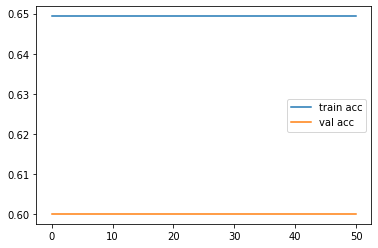

In [85]:
# accuracies

plt.plot(history.history['accuracy'], label='train acc')

plt.plot(history.history['val_accuracy'], label='val acc')

plt.legend()

plt.savefig('vgg-acc-rps-1.png')

plt.show()

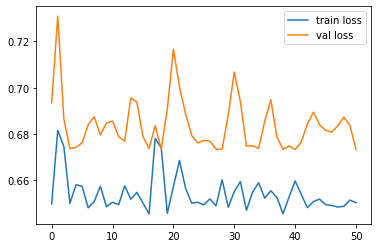

In [86]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('vgg-loss-rps-1.png')
plt.show()

In [87]:
model.evaluate(val_x,val_y,batch_size=10)

2/2 [==============================] - 0s 38ms/step - loss: 0.6734 - accuracy: 0.6000


[0.6733912229537964, 0.6000000238418579]

In [89]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np
#predict
y_pred=model.predict(val_x)
y_pred=np.argmax(y_pred,axis=1)
#get classification report
print(classification_report(y_pred,val_y))
#get confusion matrix
print(confusion_matrix(y_pred,val_y))

1/1 [==============================] - 0s 28ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.60      0.75        20

    accuracy                           0.60        20
   macro avg       0.50      0.30      0.37        20
weighted avg       1.00      0.60      0.75        20

[[ 0  0]
 [ 8 12]]


C:\Users\sathy\OneDrive\Documents\GitHub\Glioblastoma_analysis\venv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sathy\OneDrive\Documents\GitHub\Glioblastoma_analysis\venv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sathy\OneDrive\Documents\GitHub\Glioblastoma_analysis\venv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _wa